In [1]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from my_gym.envs.maze_mdp import MazeMDPEnv

import gym
import my_gym
from IPython.display import Video

from mazemdp import random_policy

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
  os.mkdir("./videos")

# Settings
NB_EPISODES = 50
TIMEOUT = 25
MAZE_SIZE = 10
MAZE_RATIO = 0.2

Matplotlib backend: module://ipykernel.pylab.backend_inline


In [2]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": MAZE_SIZE, "height": MAZE_SIZE, "ratio": MAZE_RATIO})
env.reset()
env.init_draw("The maze")

Output()

In [103]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

def actor_critic(
    mdp: MazeMDPEnv,
    nb_episodes:int,
    timeout:int,
    alpha_critic:float,
    alpha_actor:float,
    render:bool
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.ones((mdp.nb_states, mdp.action_space.size)) / mdp.action_space.size
    v = np.zeros(mdp.nb_states)
    n_update = 0

    q0 = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Actor-Critic")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw the max action from q table
            a = np.random.choice([
                i for i in range(len(q[s,:])) if q[s,i] == np.max(q[s,:])
            ])

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update critic
            delta = r + mdp.gamma * (v[y] - v[s])
            v[s] += alpha_critic * delta

            # Update actor
            q[s,a] += alpha_actor * delta

            # Normalize q so it's still probabilities
            q[s,a] /= np.sum(q[s,])

            # Update logs
            n_update += 1

            # Update the agent position
            s = y
        q_list.append(np.linalg.norm(np.maximum(q, q0)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Actor-Critic")
    return q, q_list, n_update

In [104]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

alpha_critic = 0.2
alpha_actor = 0.1
q, q_list, _ = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)

In [119]:
import time

param_critic = np.arange(0.1, 1, 0.1)
param_actor = np.arange(0.1, 1, 0.1)
n_simulation = 5

time_tab = []
n_update_tab = []

for alpha_critic in tqdm(param_critic):
  for alpha_actor in param_actor:
    time_taken = 0
    n_update = 0
    for _ in range(n_simulation):
      start = time.time()
      _, _, n = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)
      n_update += n
      time_taken += time.time() - start
    time_tab.append(time_taken/n_simulation)
    n_update_tab.append(n_update/n_simulation)

time_tab = np.array(time_tab)
n_update_tab = np.array(n_update_tab)

  0%|          | 0/9 [00:00<?, ?it/s]

In [120]:
print((time_tab).shape)
print((n_update_tab).shape)

(81,)
(81,)


In [121]:
time_tab_2d = time_tab.reshape(int(np.sqrt(time_tab.shape[0])), int(np.sqrt(time_tab.shape[0])))
n_update_tab_2d = n_update_tab.reshape(int(np.sqrt(n_update_tab.shape[0])), int(np.sqrt(n_update_tab.shape[0])))

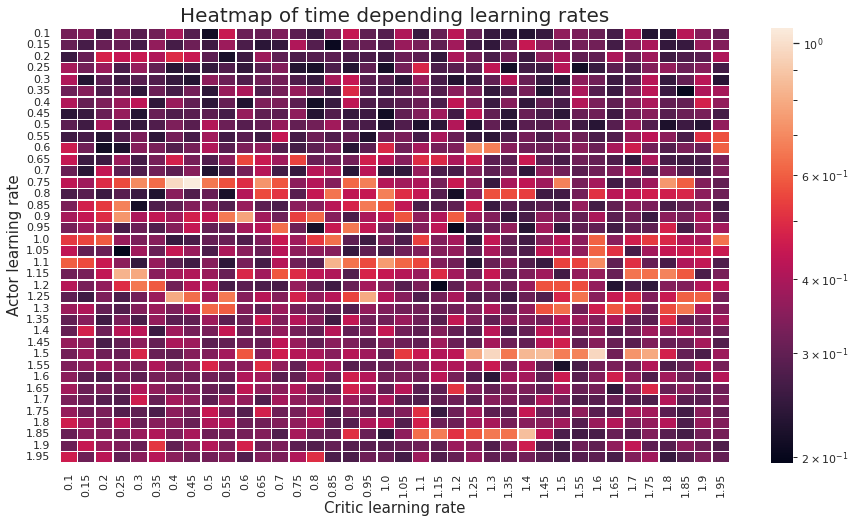

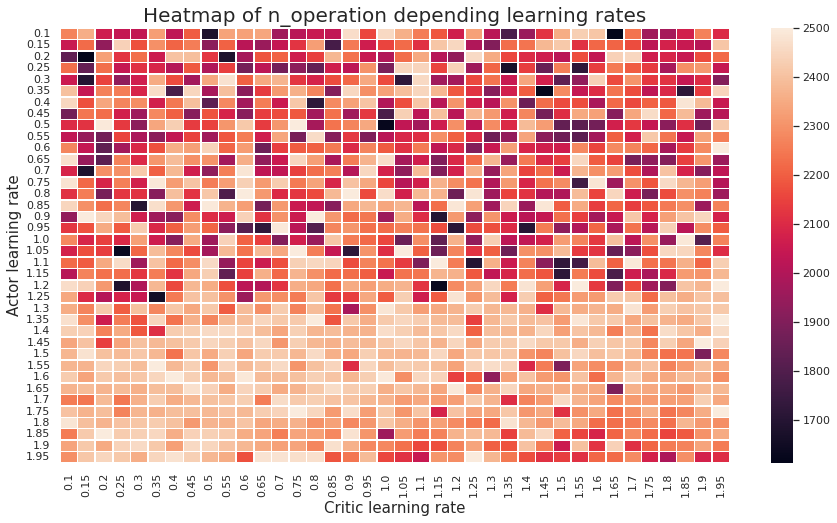

In [117]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.heatmap(time_tab_2d, linewidth=0.5, xticklabels=np.around(param_critic, 2), yticklabels=np.around(param_actor, 2))
# plt.title('Heatmap of time depending learning rates', fontsize=20)
# plt.xlabel('Critic learning rate', fontsize=15)
# plt.ylabel('Actor learning rate', fontsize=15)
# plt.show()

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(time_tab_2d, linewidth=0.5, xticklabels=np.around(param_critic, 2), yticklabels=np.around(param_actor, 2), norm=LogNorm())
plt.title('Heatmap of time depending learning rates', fontsize=20)
plt.xlabel('Critic learning rate', fontsize=15)
plt.ylabel('Actor learning rate', fontsize=15)
plt.show()

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(n_update_tab_2d, linewidth=0.5, xticklabels=np.around(param_critic, 2), yticklabels=np.around(param_actor, 2))
plt.title('Heatmap of n_operation depending learning rates', fontsize=20)
plt.xlabel('Critic learning rate', fontsize=15)
plt.ylabel('Actor learning rate', fontsize=15)
plt.show()

In [ ]:
# The mini-project consists in coding a naive actor-critic algorithm and looking for the adequate policy and critic learning rates to 
# converge as fast as possible on a set of 10x10 mazes. The global report should contain your actor-critic code, the values of 
# hyper-parameters you used, and a set of learning curves highlighting the learning behavior of your algorithm, with a short discussion of your results.

# Thanks to the heatmap we can see that the optimal parameters for this environment (maze 10x10) are around alpha_critic=?? and alpha_actor=??
# Most of the optimal pairs of learning rates confirm that the critic learning rate should be superior to the actor learning rate

# To get better estimation of those parameters, we perform multiple simulation with the same pair of parameters, then we take the mean time
# We also use the same random seed

# Now we can look at the learning by watching the Q norm



